# 集成学习

In [77]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import warnings

warnings.filterwarnings('ignore')

## 学习集成学习

In [78]:
# 用python实现概率质量函数
from scipy.special import comb
import math


def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier/2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier-k) for k in range(k_start, n_classifier+1)]
    return sum(probs)


print(ensemble_error(n_classifier=11, error=0.25))


0.03432750701904297


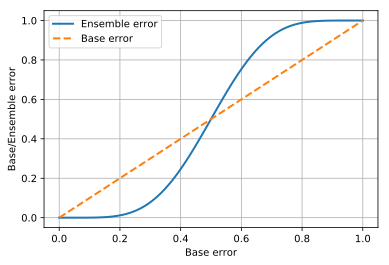

In [79]:
# 计算在error在0到1之间变化时,集成错误的变化,并绘图
import matplotlib.pyplot as plt
import numpy as np
error_range = np.arange(0, 1.01, 0.01)
ens_error = [ensemble_error(n_classifier=11, error=error) for error in error_range]
plt.plot(error_range, ens_error, label='Ensemble error', linewidth=2)
plt.plot(error_range, error_range, linestyle='--', label='Base error', linewidth=2)
plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()

## 实现一个简单的多数投票的分类器

$$
\hat{y}=\arg \max _{i} \sum_{j=1}^{m} w_{j} \chi_{A}\left(C_{j}(\boldsymbol{x})=i\right)
$$

In [80]:
np.argmax(np.bincount([0, 0, 1], weights=[0.2, 0.2, 0.6]))


1

$$
\hat{y}=\arg \max _{i} \sum_{j=1}^{m} w_{j} p_{i j}
$$

In [81]:
ex = np.array([[0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p = np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p


array([0.58, 0.42])

In [82]:
np.argmax(p)

0

用python实现MajorityVoteClassifier

In [83]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

### 结合不同的分类算法与多数投票

In [84]:
# 只读取Iris数据的sepal width和petal length两个维度的数据,并计算ROC AUC
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)


In [85]:
# 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)


In [86]:
# 训练三个不同的分类器logistic regression classifier,decision tree classifier,k-nearest neighbors classifier
# 并在组合进集成分类器前,通过10折交叉验证看看他们单独的性能表现
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']
print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: {:.2} (+/- {:.3}) [{}]'.format(scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.92 (+/- 0.201) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.154) [Decision Tree]
ROC AUC: 0.93 (+/- 0.104) [KNN]


In [87]:
# 使用MajorityVoteClassifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
print('10-fold cross validation:\n')
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print('ROC AUC: {:.2} (+/- {:.3}) [{}]'.format(scores.mean(), scores.std(), label))


10-fold cross validation:

ROC AUC: 0.92 (+/- 0.201) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.154) [Decision Tree]
ROC AUC: 0.93 (+/- 0.104) [KNN]
ROC AUC: 0.97 (+/- 0.1) [Majority Voting]


## 评估和调试集成分类器

Text(0, 0.5, 'True Positive Rate')

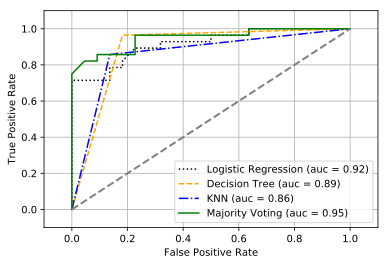

In [88]:
from sklearn.metrics import roc_curve, auc
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]  # o是negative class
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='{} (auc = {:.2})'.format(label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')


In [89]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

Text(-12.5, 4.5, 'Petal length [standardized]')

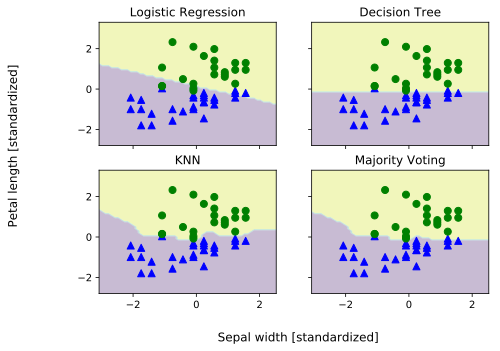

In [90]:
# 标准化训练集以便决策树的决策区域在相同的尺度
from itertools import product

all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)


In [91]:
mv_clf.get_params()

{'pipeline-1': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l2', random_state=0, solver='warn',
           tol=0.0001, verbose=0, warm_start=False)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'pipeline-2': Pipeline(memory=None,
      steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=Non

In [95]:
# 通过GridSearch调试参数
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(X_train, y_train)
cv_keys = ('mean_test_score', 'std_test_score', 'params')
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("{:.3}+/-{:.2} {}".format(grid.cv_results_[cv_keys[0]][r],
                                    grid.cv_results_[cv_keys[1]][r]/2,
                                    grid.cv_results_[cv_keys[2]][r]))


0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
1.0+/-0.0 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.967+/-0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
1.0+/-0.0 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [96]:
print('Best parameters: {} '.format(grid.best_params_))


Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0} 


In [98]:
print('Accuracy: {:.2} '.format(grid.best_score_))


Accuracy: 1.0 


## Bagging - 从boostrap samples中构建集成分类器

In [102]:
import pandas as pd
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header=None)
df_wine.columns = ['Class label', 'Alcohol',
                   'Malic acid', 'Ash',
                   'Alcalinity of ash',
                   'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols',
                   'Proanthocyanins',
                   'Color intensity', 'Hue',
                   'OD280/OD315 of diluted wines',
                   'Proline']
df_wine = df_wine[df_wine['Class label'] != 1]
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values

In [103]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)


In [113]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,
                        max_samples=1.0, # not 1
                        max_features=1.0, # not 1
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)


In [114]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies {:.3}/{:.3}'.format(tree_train, tree_test))


Decision tree train/test accuracies 1.0/0.833


In [115]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print('Bagging train/test accuracies {:.3}/{:.3}'.format(bag_train, bag_test))


Bagging train/test accuracies 1.0/0.896


Text(10.2, -1.2, 'Hue')

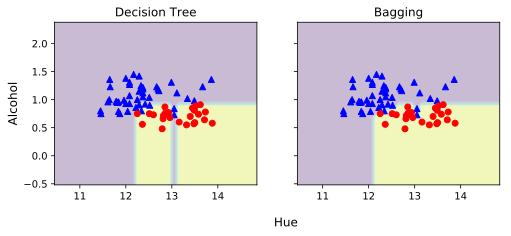

In [119]:
# 比较两种方法的决策边界
x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max()+1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))
for idx, clf, tt in zip([0, 1], [tree, bag], ['Decision Tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='red', marker='o')
    axarr[idx].set_title(tt)
axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)


bagging 优点是可以降低模型的方差，但是在降低偏差方面不有效，所以在选择集成分类器的时候需要选择低偏差的模型，比如：未修剪的决策树

## 利用adaboost来提升弱学习器